# Solving orbital equations with different algorithms

This notebook was adapted from `Orbit_games.ipynb`.



For the gravitational potential energy below, we plot the orbits for the two body problem in cartesian coordinates.

$\begin{align}
   U(r) = -\frac{G m_1 m_2}{r}
\end{align}$

The leapfrog method evaluates $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot r_{i+1/2} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   r_{i+1} &= r_i +  \dot r_{i+1/2}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$
 
 But we don't want these lame polar coordinates, we want cartesian, and so we must start with the Lagrangian in cartesian to find the equations of motion:
 $\begin{align}
 \mathcal{L} = \frac{1}{2} \mu (\dot{r}^2 + (r \dot\theta)^2) + \frac{G m_1 m_2}{r}
 \end{align}$
 
 where
 $\begin{align}
 r = \sqrt{x^2 + y^2} 
 \end{align}$
 
 and
 $\begin{align}
 x = x_1 - x_2, y = y_1 - y_2
 \end{align}$
 
 so
 $\begin{align}
 \mathcal{L} = \frac{1}{2} \mu ((\dot{x_1} - \dot{x_2})^2 + (\dot{y_1} - \dot{y_2})^2) + \frac{G m_1 m_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}
 \end{align}$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [57]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [70]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = G m1 m2/r.  I will use polar in the notes and type
    cartesian in the code. It's a lot to repeat you know?
    Leapfrog algorithm for integration of 
    ordinary differential equations implemented. 
    """
    
    def __init__(self, G=1., m_1=1., m_2=1.):
        self.G = G
        self.m_1 = m_1
        self.m_2 = m_2
        self.mu = m_1*m_2/(m_1 + m_2)
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: [dx_i/dt, d^2x_i/dt^2, dy_i/dt, d^2y_i/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x_1(t), y[1] = dx_1/dt, y[2] = x_2(t), y[3] = dx_2/dt,
                                    y[4] = y_1(t), y[5] = dy_1/dt, y[6] = y_2(t), y[7] = dy_2/dt
            
        """
        constant = self.G*self.m_1*self.m_2
        denom = np.sqrt((y[0] - y[2])**2 + (y[4] - y[6])**2)**3
        
        return [y[1],
                constant * (y[2] - y[0])/denom,
                y[3],
                constant *  (y[0] - y[2])/denom,
                y[5],
                constant *  (y[6] - y[4])/denom,
                y[7],
                constant *  (y[4] - y[6])/denom]
    
    
    def solve_ode(self, t_pts, x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20]  
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x_1, x_dot_1, x_2, x_dot_2, y_1, y_dot_1, y_2, y_dot_2 = solution.y
        return x_1, x_dot_1, x_2, x_dot_2, y_1, y_dot_1, y_2, y_dot_2
    
    def solve_ode_Leapfrog(self, t_pts, x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        x_1 = np.zeros(num_t_pts)
        x_dot_1 = np.zeros(num_t_pts)
        x_dot_1_half = np.zeros(num_t_pts)
        
        x_2 = np.zeros(num_t_pts)
        x_dot_2 = np.zeros(num_t_pts)
        x_dot_2_half = np.zeros(num_t_pts)
        
        y_1 = np.zeros(num_t_pts)
        y_dot_1 = np.zeros(num_t_pts)
        y_dot_1_half = np.zeros(num_t_pts)
        
        y_2 = np.zeros(num_t_pts)
        y_dot_2 = np.zeros(num_t_pts)
        y_dot_2_half = np.zeros(num_t_pts)

        
        # initial conditions
        x_1[0] = x_10
        x_dot_1[0] = x_dot_10
        x_2[0] = x_20
        x_dot_2[0] = x_dot_20
        y_1[0] = y_10
        y_dot_1[0] = y_dot_10
        y_2[0] = y_20
        y_dot_2[0] = y_dot_20
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x_1[i], x_dot_1[i], x_2[i], x_dot_2[i], y_1[i], y_dot_1[i], y_2[i], y_dot_2[i]]
            
            #y = [r[i], r_dot[i], phi[i]]
            
            x_dot_1_half[i] = x_dot_1[i] + self.dy_dt(t, y)[1]*delta_t/2.
            x_1[i+1] = x_1[i] + x_dot_1_half[i]*delta_t
            
            x_dot_2_half[i] = x_dot_2[i] + self.dy_dt(t, y)[3]*delta_t/2.
            x_2[i+1] = x_2[i] + x_dot_2_half[i]*delta_t
            
            y_dot_1_half[i] = y_dot_1[i] + self.dy_dt(t, y)[5]*delta_t/2.
            y_1[i+1] = y_1[i] + y_dot_1_half[i]*delta_t
            
            y_dot_2_half[i] = y_dot_2[i] + self.dy_dt(t, y)[7]*delta_t/2.
            y_2[i+1] = y_2[i] + y_dot_2_half[i]*delta_t
            
            #r_dot_half[i] = r_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            #r[i+1] = r[i] + r_dot_half[i] * delta_t
            
            y = [x_1[i+1], x_dot_1[i], x_2[i+1], x_dot_2[i], y_1[i+1], y_dot_1[i], y_2[i+1], y_dot_2[i]]
            
            #y = [r[i+1], r_dot[i], phi[i]]
            
            x_dot_1[i+1] = x_dot_1_half[i] + self.dy_dt(t,y)[1] * delta_t/2.
            x_dot_2[i+1] = x_dot_2_half[i] + self.dy_dt(t,y)[3] * delta_t/2.
            y_dot_1[i+1] = y_dot_1_half[i] + self.dy_dt(t,y)[5] * delta_t/2.
            y_dot_2[i+1] = y_dot_2_half[i] + self.dy_dt(t,y)[7] * delta_t/2.
            
            #r_dot[i+1] = r_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            #y_1[i+1] = y_1[i] + self.dy_dt(t,y)[2] * delta_t
            #y_2[i+1] = y_2[i] + self.dy_dt(t,y)[4] * delta_t
            #phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return x_1, x_dot_1, x_2, x_dot_2, y_1, y_dot_1, y_2, y_dot_2
    
    def energy(self, t_pts, x_1, x_dot_1, x_2, x_dot_2, y_1, y_dot_1, y_2, y_dot_2):
        """Evaluate the energy as a function of time"""
        return 0.5*self.m_1*((x_dot_1)**2 + (y_dot_1)**2)\
                + 0.5*self.m_2*((x_dot_2)**2 + (y_dot_2)**2)\
                - self.G*self.m_1*self.m_2/np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)

In [71]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Plot orbit 
I made the two masses equal.

In [72]:
#Parameters

G = 10.
m_1 = 1.
m_2 = 1.

#Instantiate the orbit
o1 = Orbit(G=G, m_1=m_1, m_2=m_2)

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Initial conditions
x_10, x_dot_10 = 1., -1.
y_10, y_dot_10 = 1., 1.
x_20, x_dot_20 = -(m_1 / m_2) * x_10, -(m_1 / m_2) * x_dot_10
y_20, y_dot_20 = -(m_1 / m_2) * y_10, -(m_1 / m_2) * y_dot_10

x_1_pts, x_dot_1_pts, x_2_pts, x_dot_2_pts, y_1_pts, y_dot_1_pts, y_2_pts, y_dot_2_pts\
                            = o1.solve_ode(t_pts, x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20)


x_1_ptsLF, x_dot_1_ptsLF, x_2_ptsLF, x_dot_2_ptsLF, y_1_ptsLF, y_dot_1_ptsLF, y_2_ptsLF, y_dot_2_ptsLF\
                        = o1.solve_ode_Leapfrog(t_pts, x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20)

#r_pts_LF, r_dot_pts_LF, phi_pts_LF \
                           #= o1.solve_ode_Leapfrog(t_pts, r_0, r_dot_0, phi_0)

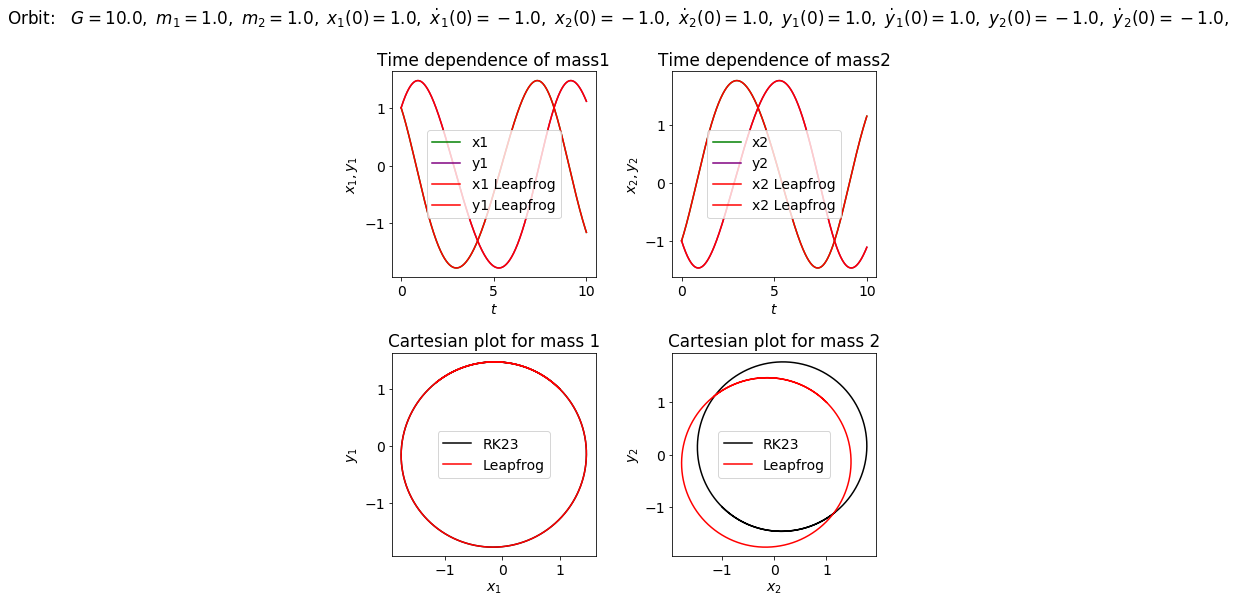

In [73]:
fig_4 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                rf' $G = {o1.G},$' + \
                rf' $m_1 = {o1.m_1},$' + \
                rf' $m_2 = {o1.m_2},$' + \
                rf' $x_1(0) = {x_10:.1f},$' + \
                rf' $\dot x_1(0) = {x_dot_10:.1f},$' + \
                rf' $x_2(0) = {x_20:.1f},$' + \
                rf' $\dot x_2(0) = {x_dot_20:.1f},$' + \
                rf' $y_1(0) = {y_10:.1f},$' + \
                rf' $\dot y_1(0) = {y_dot_10:.1f},$' + \
                rf' $y_2(0) = {y_20:.1f},$' + \
                rf' $\dot y_2(0) = {y_dot_20:.1f},$' + \
                '\n'
fig_4.suptitle(overall_title, va='baseline')

ax_4a = fig_4.add_subplot(2,2,1)
ax_4a.plot(t_pts, x_1_pts, color='green', label='x1')
ax_4a.plot(t_pts, y_1_pts, color='purple', label='y1')
ax_4a.plot(t_pts, x_1_ptsLF, color='red', label='x1 Leapfrog')
ax_4a.plot(t_pts, y_1_ptsLF, color='red', label='y1 Leapfrog')
ax_4a.set_xlabel(r'$t$')
ax_4a.set_ylabel(r'$x_1, y_1$')
ax_4a.set_title('Time dependence of mass1')
ax_4a.legend()

ax_4b = fig_4.add_subplot(2,2,2)
ax_4b.plot(t_pts, x_2_pts, color='green', label='x2')
ax_4b.plot(t_pts, y_2_pts, color='purple', label='y2')
ax_4b.plot(t_pts, x_2_ptsLF, color='red', label='x2 Leapfrog')
ax_4b.plot(t_pts, y_2_ptsLF, color='red', label='x2 Leapfrog')
ax_4b.set_xlabel(r'$t$')
ax_4b.set_ylabel(r'$x_2, y_2$')
ax_4b.set_title('Time dependence of mass2')
ax_4b.legend()


ax_4c = fig_4.add_subplot(2,2,3)
ax_4c.plot(x_1_pts, y_1_pts, 
           color='black', label='RK23')
ax_4c.plot(x_1_ptsLF, 
           y_1_ptsLF, 
           color='red', label='Leapfrog')
ax_4c.set_xlabel(r'$x_1$')
ax_4c.set_ylabel(r'$y_1$')
ax_4c.set_aspect('equal')
ax_4c.set_title('Cartesian plot for mass 1')
ax_4c.legend()

ax_4d = fig_4.add_subplot(2,2,4)
ax_4d.plot(x_2_pts, y_2_pts, 
           color='black', label='RK23')
ax_4d.plot(x_1_ptsLF, 
           y_1_ptsLF, 
           color='red', label='Leapfrog')
ax_4d.set_xlabel(r'$x_2$')
ax_4d.set_ylabel(r'$y_2$')
ax_4d.set_aspect('equal')
ax_4d.set_title('Cartesian plot for mass 2')
ax_4d.legend()

fig_4.tight_layout()



## Check conservation of energy
Find the energy and compare the changes in energy with time. Leapfrog is going to be better.

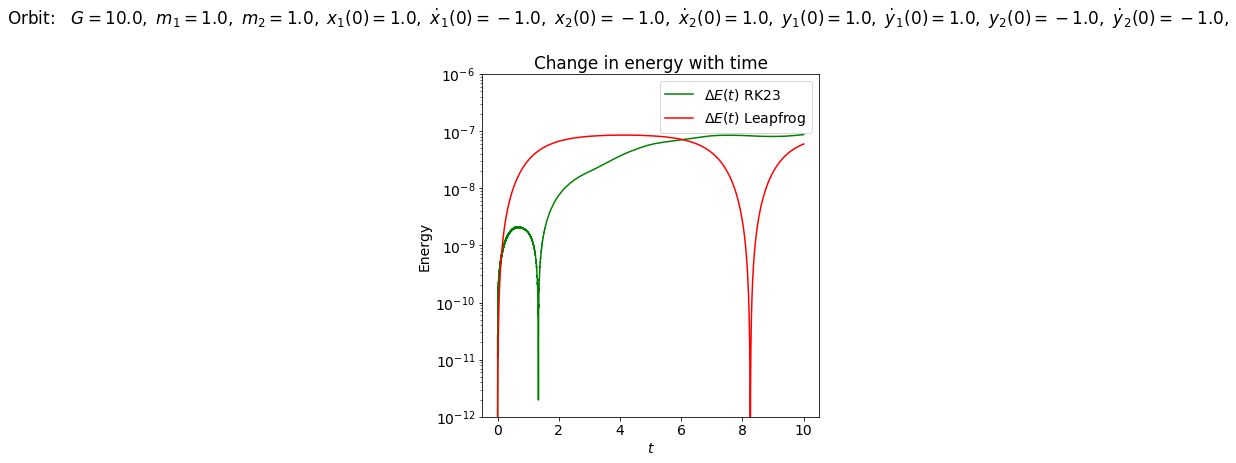

In [75]:
E_tot_pts = o1.energy(t_pts, x_1_pts, x_dot_1_pts, x_2_pts, x_dot_2_pts, y_1_pts, y_dot_1_pts, y_2_pts, y_dot_2_pts)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = o1.energy(t_pts, x_1_ptsLF, x_dot_1_ptsLF, x_2_ptsLF, x_dot_2_ptsLF, y_1_ptsLF, y_dot_1_ptsLF, y_2_ptsLF, y_dot_2_ptsLF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

#Plot!
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Orbit:  ' + \
                rf' $G = {o1.G},$' + \
                rf' $m_1 = {o1.m_1},$' + \
                rf' $m_2 = {o1.m_2},$' + \
                rf' $x_1(0) = {x_10:.1f},$' + \
                rf' $\dot x_1(0) = {x_dot_10:.1f},$' + \
                rf' $x_2(0) = {x_20:.1f},$' + \
                rf' $\dot x_2(0) = {x_dot_20:.1f},$' + \
                rf' $y_1(0) = {y_10:.1f},$' + \
                rf' $\dot y_1(0) = {y_dot_10:.1f},$' + \
                rf' $y_2(0) = {y_20:.1f},$' + \
                rf' $\dot y_2(0) = {y_dot_20:.1f},$' + \
                '\n'    
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
#ax_5a.semilogy(t_pts, np.abs(E_tot_pts), color='black', label=r'$E(t)$')
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_5a.set_ylim(1.e-12, 1.e-6)    
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy with time')
ax_5a.legend()

fig_5.tight_layout()



## Equivalent situation in relative coordinates
If we make one of the masses really large we should achieve the orbits considered in class: we effectively used the one body problem in class. So, we should find that if say the second mass is large, then the second mass should effectively be stationary.

In [55]:
#Parameters
G = 100.
m_1 = 1.
m_2 = 10000.

#Instantiate the orbit
o1 = Orbit(G=G, m_1=m_1, m_2=m_2)

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Initial conditions
x_10, x_dot_10 = 1., -1.
y_10, y_dot_10 = 1., 1.
x_20, x_dot_20 = -(m_1 / m_2) * x_10, -(m_1 / m_2) * x_dot_10
y_20, y_dot_20 = -(m_1 / m_2) * y_10, -(m_1 / m_2) * y_dot_10

x_1_pts, x_dot_1_pts, x_2_pts, x_dot_2_pts, y_1_pts, y_dot_1_pts, y_2_pts, y_dot_2_pts\
                            = o1.solve_ode(t_pts, x_10, x_dot_10, x_20, x_dot_20, y_10, y_dot_10, y_20, y_dot_20)


fig_4 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                rf' $G = {o1.G},$' + \
                rf' $m_1 = {o1.m_1},$' + \
                rf' $m_2 = {o1.m_2},$' + \
                rf' $x_1(0) = {x_10:.1f},$' + \
                rf' $\dot x_1(0) = {x_dot_10:.1f},$' + \
                rf' $x_2(0) = {x_20:.1f},$' + \
                rf' $\dot x_2(0) = {x_dot_20:.1f},$' + \
                rf' $y_1(0) = {y_10:.1f},$' + \
                rf' $\dot y_1(0) = {y_dot_10:.1f},$' + \
                rf' $y_2(0) = {y_20:.1f},$' + \
                rf' $\dot y_2(0) = {y_dot_20:.1f},$' + \
                '\n'
fig_4.suptitle(overall_title, va='baseline')

ax_4a = fig_4.add_subplot(2,2,1)
ax_4a.plot(t_pts, x_1_pts, color='green', label='x1')
ax_4a.plot(t_pts, y_1_pts, color='purple', label='y1')
#ax_4a.plot(t_pts, r_pts_LF, color='red', label='Leapfrog')
ax_4a.set_xlabel(r'$t$')
ax_4a.set_ylabel(r'$x_1, y_1$')
ax_4a.set_title('Time dependence of mass1')
ax_4a.legend()

ax_4b = fig_4.add_subplot(2,2,2)
ax_4b.plot(t_pts, x_2_pts, color='green', label='x2')
ax_4b.plot(t_pts, y_2_pts, color='purple', label='y2')
#ax_4a.plot(t_pts, r_pts_LF, color='red', label='Leapfrog')
ax_4b.set_xlabel(r'$t$')
ax_4b.set_ylabel(r'$x_2, y_2$')
ax_4b.set_title('Time dependence of mass2')
ax_4b.legend()


ax_4c = fig_4.add_subplot(2,2,3)
ax_4c.plot(x_1_pts, y_1_pts, 
           color='black', label='RK23')
#ax_4c.plot(r_pts_LF*np.cos(phi_pts_LF), 
           #r_pts_LF*np.sin(phi_pts_LF), 
           #color='red', label='Leapfrog')
ax_4c.set_xlabel(r'$x_1$')
ax_4c.set_ylabel(r'$y_1$')
ax_4c.set_aspect('equal')
ax_4c.set_title('Cartesian plot for mass 1')
ax_4c.legend()

ax_4d = fig_4.add_subplot(2,2,4)
ax_4d.plot(x_2_pts, y_2_pts, 
           color='black', label='RK23')
#ax_4c.plot(r_pts_LF*np.cos(phi_pts_LF), 
           #r_pts_LF*np.sin(phi_pts_LF), 
           #color='red', label='Leapfrog')
ax_4d.set_xlabel(r'$x_2$')
ax_4d.set_ylabel(r'$y_2$')
ax_4d.set_aspect('equal')
ax_4d.set_title('Cartesian plot for mass 2')
ax_4d.legend()

fig_4.tight_layout()



KeyboardInterrupt: 

In [ ]:
 #I don't know why i can't get this to work I can't figure out what the G value should be